### Libraries

In [69]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

### Load Data

In [70]:
query = "Query_AI-magazines-mediacloud-2021-24" # Load feater file
FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)

df = df[df['text'] != ''] # Drop rows where the 'Name' is empty
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer

df = df.reset_index(drop=True) # Reset the index of the DataFrame and drop the old index column


df.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG
1827,8857fd357edd834172feb1a1b235a2463f3947619e6f05...,2024-08-29 02:33:04.036438,en,technologyreview.com,technologyreview.com,2021-07-12,Cybersecurity can protect data. How about elev...,https://www.technologyreview.com/2021/07/12/10...,2021,Sponsored\nCybersecurity can protect data. How...,True,"[Florida, South Africa, South Africa, Cambridg...","[withCortex Xpanse, Greg Belanger, Laurel Ruma...","[Palo Alto Networks, CBRE, Colonial Pipeline, ..."


### Clean Data

In [71]:
def concat_entities(row):
    return list(row['GPE']) + list(row['IND']) + list(row['ORG'])
df['entities'] = df.apply(concat_entities, axis=1) # Merge entities

df = df.drop(['text_downloaded', 'indexed_date', 'language', 'media_url', 'id', 'text', 'publish_date', 'media_name', 'GPE', 'IND', 'ORG'], axis=1) # Delete unised arrows

df.sample(1)

,title,url,year,entities
1382,A guided tour of the new MIT Museum,https://www.technologyreview.com/2023/02/21/10...,2023,"[US, David Nuñez, David Nuñez, Nuñez, Nuñez, N..."


### Temperature

In [72]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,title,url,year,entities,temperature,color
132,OpenAI Just Released SearchGPT. It’s Already E...,https://www.theatlantic.com/technology/archive...,2024,"[boone north carolina, Boone, Boone, Asheville...",2,#0000ff
1265,Elon Musk founds new AI company called X.AI,https://www.theverge.com/2023/4/14/23684005/el...,2023,"[Nevada, Elon Musk, Musk, Jared Birchall, Musk...",1,#5500aa
540,"How to Not Get Scammed Out of $50,000",https://www.wired.com/story/how-to-not-get-sca...,2024,"[the United States, US, US, US, US, Russia, Ch...",2,#0000ff


### Term Frequency

In [73]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["entities"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 1229744 edges.
It has only fully disconnected 3 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '146.80851063829786' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[site, ['y', 'x']] = [x,y]
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '472.3404255

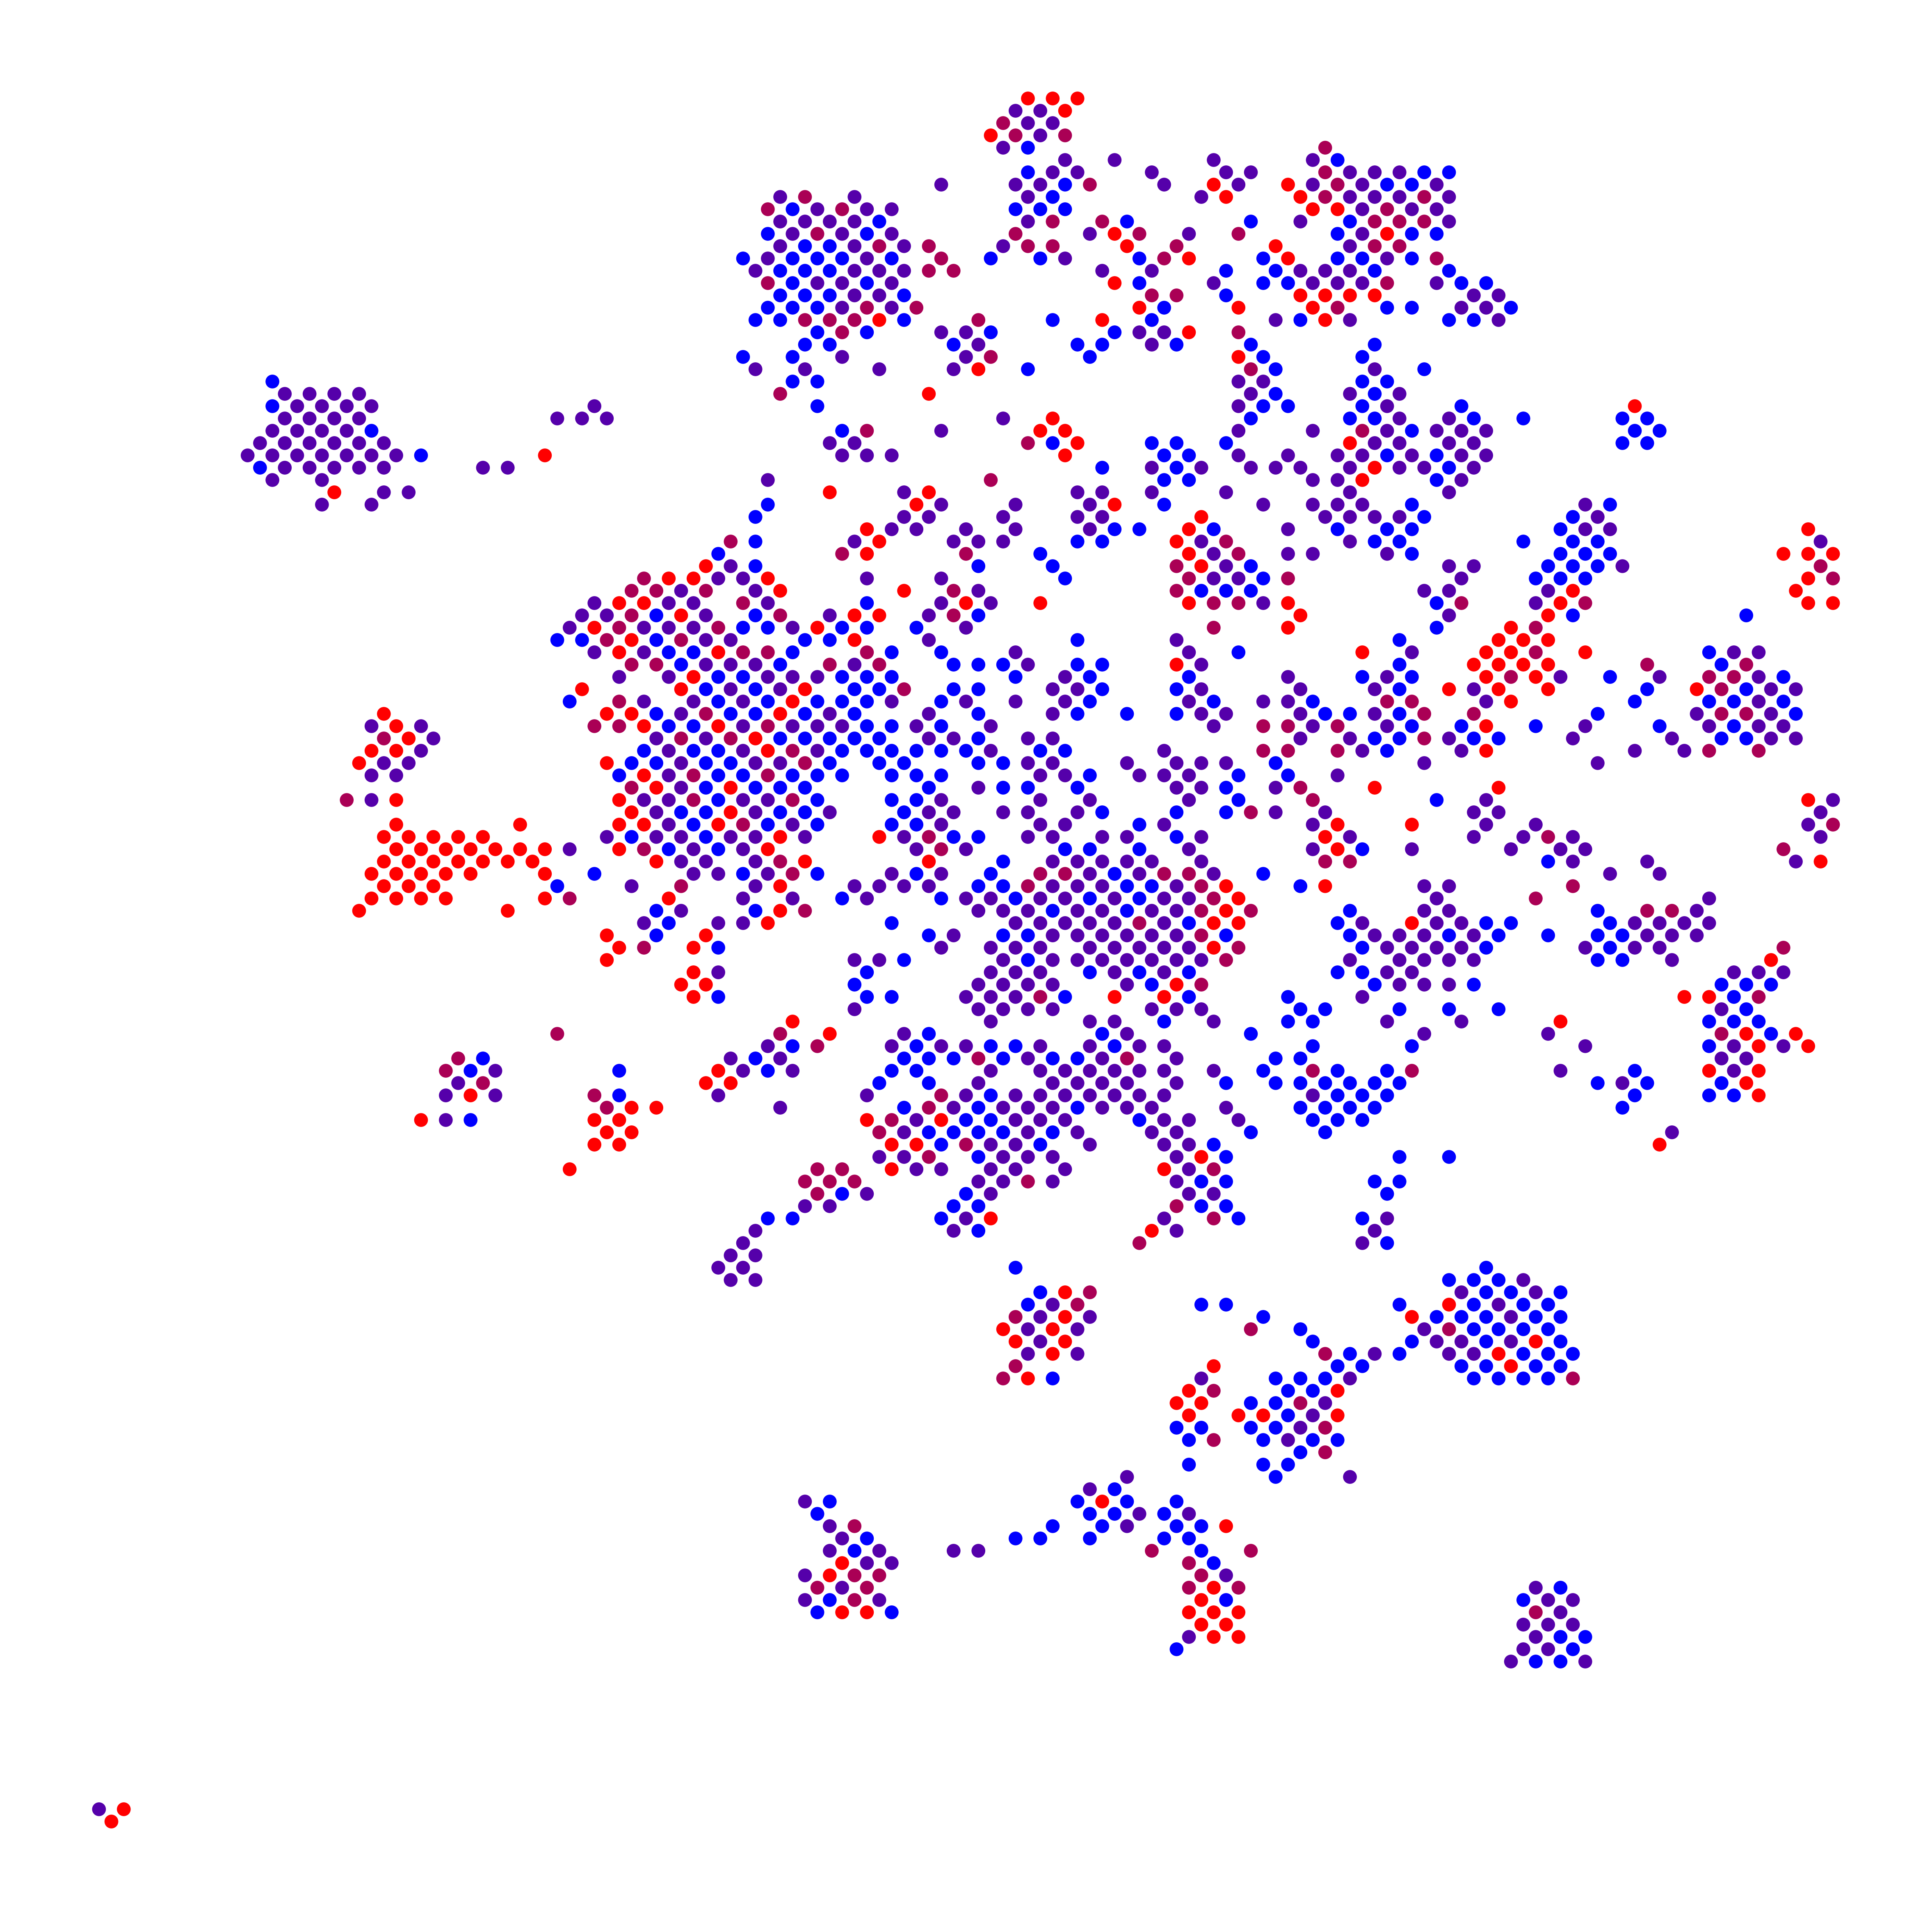

In [82]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    # random_state=5,
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")


## Clustering

In [95]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=5,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=5, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] < 0)],
    "n_",
    df,
)

df.sample(3)

,title,url,year,entities,temperature,color,x,y,cluster
141,How’s AI self-regulation going?,https://www.technologyreview.com/2024/07/23/10...,2024,"[US, US, US, US, US, US, the United States, US...",2,#0000ff,638.297872,670.212766,-1
581,Three ways we can fight deepfake porn,https://www.technologyreview.com/2024/01/29/10...,2024,"[US, California, Virginia, New York, Virginia,...",2,#0000ff,504.255319,574.468085,-1
257,Biotech companies are trying to make milk with...,https://www.technologyreview.com/2024/06/14/10...,2024,"[US, San Francisco, Florida, Gainesville, US, ...",2,#0000ff,370.212766,746.808511,p_22


{'p_15', 'n_4', 'p_36', 'p_26', 'p_7', 'p_37', 'p_16', 'n_9', 'p_20', 'n_14', 'p_33', 'p_19', 'p_30', 'p_1', 'p_39', 'p_22', 'p_40', 'n_5', 'p_24', 'p_5', 'p_6', 'n_10', 'p_8', 'p_31', '-1', 'p_38', 'p_41', 'n_7', 'p_28', 'p_18', 'p_23', 'p_12', 'p_17', 'p_2', 'p_43', 'p_9', 'p_29', 'p_3', 'n_1', 'n_0', 'n_3', 'p_0', 'n_2', 'p_25', 'n_6', 'p_27', 'p_35', 'n_11', 'n_15', 'p_34', 'p_21', 'p_13', 'p_11', 'p_44', 'p_45', 'p_42', 'n_13', 'p_10', 'p_4', 'p_32', 'p_14', 'n_8', 'n_12'}


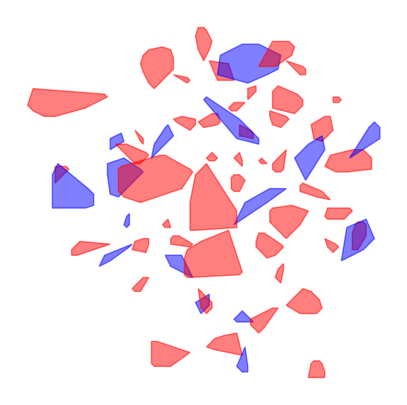

In [96]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [101]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,title,url,year,entities,temperature,color,x,y,cluster
1211,"Ed Sheeran Is Older, Wiser, and Still Quite Bland",https://www.theatlantic.com/culture/archive/20...,2023,"[Australia, New Zealand, Ed Sheeran, Bland, Ed...",1,#5500aa,855.319149,606.382979,p_9
